In [1]:
import pandas as pd

dat = pd.read_csv('Crimes_-_2001_to_present.csv')
dat.head(5)

C:\Users\henry\AppData\Local\Temp\ipykernel_48916\710893603.py:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv('Crimes_-_2001_to_present.csv')


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,8.0,45.0,11,NaN,NaN,2001,08/05/2017 03:50:08 PM,NaN,NaN,NaN
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as Fs

spark = SparkSession.builder.getOrCreate()
df_spark = spark.read.options(header = 'True', inferSchema='True').csv('Crimes_-_2001_to_present.csv')

In [3]:
df_spark.show(5)

+--------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|                Date|               Block|IUCR|       Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|11034701|   JA366925|01/01/2001 11:00:...|     016XX E 86TH PL|1153| DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|           RESIDENCE| false|   false| 412|       4|   8|            45|      

In [6]:
from pyspark.sql.functions import to_date, month, col

df_spark = df_spark.withColumn('Date', to_date(col("Date"), 'MM/dd/yyyy hh:mm:ss a'))
df_spark = df_spark.withColumn("Month", month(col("Date")))

# Register the DataFrame as a temporary table
df_spark.createOrReplaceTempView("crimes")

# Use SparkSQL to find the count of crime events by month
result = spark.sql("""
    SELECT Month, COUNT(*) as crime_events
    FROM crimes
    GROUP BY Month
    ORDER BY Month
""")

# Collect the results to a Pandas DataFrame
pd_result = result.toPandas()

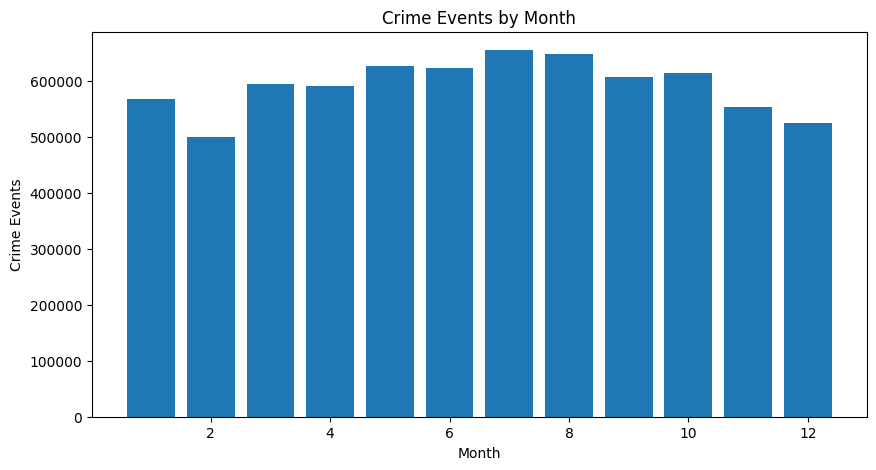

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(pd_result['Month'], pd_result['crime_events'])
plt.xlabel('Month')
plt.ylabel('Crime Events')
plt.title('Crime Events by Month')
plt.show()

In [9]:
df_spark.show(5)

+--------+-----------+----------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+-----+
|      ID|Case Number|      Date|               Block|IUCR|       Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|Month|
+--------+-----------+----------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+-----+
|11034701|   JA366925|2001-01-01|     016XX E 86TH PL|1153| DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|           RESIDENCE| false|   false| 412|       4|   8|            45|      11|        null|      

In [10]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder.appName("crime_analysis").getOrCreate()

# Read the dataframe

# Filter events of the last 3 years
df_3years = df_spark.filter(df_spark['Year'] >= 2020)

# Count and sort crime events by block
top10_blocks = df_3years.groupBy("Block").count().orderBy('count', ascending=False).limit(10)
top10_blocks.show()


+--------------------+-----+
|               Block|count|
+--------------------+-----+
|    001XX N STATE ST|  231|
| 0000X W TERMINAL ST|   96|
|008XX N MICHIGAN AVE|   90|
|064XX S DR MARTIN...|   75|
|  076XX S CICERO AVE|   69|
|     0000X W 79TH ST|   67|
|    100XX W OHARE ST|   66|
|    0000X S STATE ST|   66|
|   025XX W CERMAK RD|   64|
| 083XX S STEWART AVE|   61|
+--------------------+-----+



In [3]:
from pyspark import SparkConf, SparkContext
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

from pyspark import SparkConf, SparkContext

conf = SparkConf().setAppName("CrimeAnalysis")
sc = SparkContext(conf=conf)
# crime_data = sc.textFile('Crimes_-_2001_to_present.csv')


23/05/24 22:16:19 WARN Utils: Your hostname, henry-workstation resolves to a loopback address: 127.0.1.1; using 192.168.1.245 instead (on interface wlp4s0)
23/05/24 22:16:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/24 22:16:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [16]:
def check_year(x):
    try:
        year = int(x[17])
        return year in [2020,2021,2022]
    except :
        print(f"ValueError for record {x}")
        return False

# data_last_3_years = data.filter(check_year)


In [9]:
time.strftime("%Y")

'2023'

In [3]:
myRDD = sc.parallelize([1,2,3,4,5],2)
myRDD.collect()

[1, 2, 3, 4, 5]

In [4]:
import time
# Read the data
data = sc.textFile("Crimes_-_2001_to_present.csv")
header = data.first()
data = data.filter(lambda line: line != header).map(lambda line: line.split(","))

data_year = data.map(lambda x: ())
# Filter to get data from last 3 years
current_year = int(time.strftime("%Y"))
data_last_3_years = data.filter(check_year)

# Get the block and its count
block_counts = data_last_3_years.map(lambda x: (x[3][:5], 1)).reduceByKey(lambda a, b: a + b)

# Get top 10 blocks
top_10_blocks = block_counts.sortBy(lambda x: x[1], ascending=False).take(10)

print(top_10_blocks)

NameError: name 'check_year' is not defined

In [18]:
with open("liang_2_1.txt", "w") as file:
        file.write("Block, Count\n")
        for block, count in top_10_blocks:
            file.write(f"{block}, {count}\n")

In [5]:
from datetime import datetime, timedelta
data = sc.textFile("Crimes_-_2001_to_present.csv")
header = data.first()
data = data.filter(lambda line: line != header).map(lambda line: line.split(","))
def check_year(x):
    try:
        year = int(x[17])
        return year >= 2018
    except :
        print(f"ValueError for record {x}")
        return False
    
# Filter the DataFrame for the last five years
df_filtered = data.filter(lambda x: x[17] in ['2020', '2019', '2018', '2017', '2016'])

In [6]:
x = df_filtered.map(lambda row: ((row[10], row[17]), 1)).reduceByKey(lambda a, b: a + b)

In [7]:
x.take(5)

[(('1712', '2016'), 1077),
 (('2513', '2018'), 433),
 (('0412', '2017'), 1080),
 (('1224', '2018'), 1108),
 (('0214', '2018'), 652)]

In [8]:
# Continue from where your code left off.
# Transform the data to have the beat as key and list of values as value.
beat_year = x.map(lambda x: (x[0][0], (x[0][1], x[1])))

# Group by the beat key and collect all values for each key into a list.
beat_grouped = beat_year.groupByKey().mapValues(list)

beat_counts = beat_grouped.mapValues(lambda x: [count for year, count in x])

# Finally, collect the RDD into a dictionary.
beat_dict = beat_counts.collectAsMap()
beat_dict

{'0915': [831, 816, 858, 208, 943],
 '1215': [171, 1097, 804, 870, 844],
 '0831': [1216, 1413, 1329, 1232, 345],
 '1013': [980, 1114, 971, 244, 1058],
 '1114': [624, 781, 732, 639, 171],
 '0722': [730, 720, 720, 210, 763],
 '0815': [1106, 1030, 1199, 264, 973],
 '0433': [826, 750, 794, 633, 181],
 '0231': [836, 171, 874, 757, 786],
 '2535': [963, 258, 1030, 805, 858],
 '1633': [246, 956, 951, 827, 974],
 '0313': [930, 921, 196, 820, 803],
 '1622': [819, 955, 226, 929, 915],
 '2013': [110, 505, 560, 428, 454],
 '1812': [711, 691, 823, 174, 632],
 '1411': [147, 632, 684, 581, 616],
 '2422': [1079, 1327, 1265, 1297, 330],
 '0632': [1518, 369, 1576, 1466, 1628],
 '1931': [644, 657, 175, 695, 643],
 '0621': [1715, 1717, 402, 1756, 1760],
 '1032': [576, 546, 519, 558, 154],
 '0834': [291, 1181, 1502, 1162, 1141],
 '0211': [904, 821, 229, 915, 815],
 '1011': [1738, 1932, 1858, 479, 1795],
 '1832': [1025, 1215, 232, 1109, 865],
 '0932': [161, 669, 746, 792, 820],
 '1134': [1429, 1168, 1507, 14

In [10]:
import numpy as np
corr_mat = np.corrcoef(list(beat_dict.values()))

In [13]:
import numpy as np
corr_dict = {}
beat_keys = list(beat_dict.keys())
for i in range(len(beat_keys)):
    for j in range(i+1, len(beat_keys)):
        beat1 = beat_keys[i]
        beat2 = beat_keys[j]
        corr = corr_mat[i, j]
        corr_dict[(beat1, beat2)] = corr
sorted_corr_dict = {k: v for k, v in sorted(corr_dict.items(), key=lambda item: abs(item[1]), reverse=True)}

In [ ]:
emanuel_years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
daley_years = ['1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011']



In [22]:
from datetime import datetime, timedelta
data = sc.textFile("Crimes_-_2001_to_present.csv")
header = data.first()
data = data.filter(lambda line: line != header).map(lambda line: line.split(","))
def check_year_e(x):
    emanuel_years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
    try:
        year = x[17]
        return year in emanuel_years
    except :
        print(f"ValueError for record {x}")
        return False
    
df_filtered_e = data.filter(check_year_e)
beat_year_e = df_filtered_e.map(lambda row: ((row[10], row[17]), 1))\
                        .reduceByKey(lambda a, b: a + b)\
                        .map(lambda x: (x[0][0], (x[0][1], x[1])))
beat_grouped_e = beat_year_e.groupByKey().mapValues(list)
beat_counts_e = beat_grouped_e.mapValues(lambda x: [count for year, count in x])
beat_dict_e = beat_counts_e.collectAsMap()
beat_dict_e

{'0915': [831, 1298, 913, 1092, 816, 1270, 858, 943, 994],
 '0831': [1216, 1413, 1349, 1329, 1354, 1232, 1772, 1518, 2059],
 '1013': [980, 1114, 971, 1008, 1002, 1227, 1029, 1058, 1186],
 '1114': [624, 781, 871, 732, 984, 1177, 639, 1083, 667],
 '1215': [1097, 804, 844, 4, 79, 724, 789, 870, 844],
 '0231': [930, 836, 874, 925, 819, 235, 757, 786, 738],
 '0722': [730, 710, 969, 720, 720, 738, 763, 860, 973],
 '0815': [1106, 1399, 1030, 1199, 1135, 1111, 1521, 973, 1449],
 '0433': [826, 750, 686, 794, 804, 633, 921, 1063, 965],
 '2322': [507, 69],
 '1812': [832, 711, 536, 606, 691, 901, 823, 741, 632],
 '1622': [990, 1226, 1031, 819, 955, 1065, 929, 1144, 915],
 '1411': [948, 718, 632, 684, 581, 916, 770, 616, 599],
 '2535': [963, 1497, 1238, 1030, 1650, 805, 1036, 936, 858],
 '0313': [1279, 930, 917, 921, 1150, 1479, 820, 803, 835],
 '2013': [404, 553, 505, 560, 458, 557, 412, 428, 454],
 '1633': [956, 1036, 1185, 951, 1220, 1270, 827, 974, 985],
 '1032': [573, 669, 576, 525, 758, 767, 

In [23]:
def check_year_d(x):
    daley_years = ['1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011']
    try:
        year = x[17]
        return year in daley_years
    except :
        print(f"ValueError for record {x}")
        return False
    
df_filtered_d = data.filter(check_year_d)
beat_year_d = df_filtered_d.map(lambda row: ((row[10], row[17]), 1))\
                        .reduceByKey(lambda a, b: a + b)\
                        .map(lambda x: (x[0][0], (x[0][1], x[1])))
beat_grouped_d = beat_year_d.groupByKey().mapValues(list)
beat_counts_d = beat_grouped_d.mapValues(lambda x: [count for year, count in x])
beat_dict_d = beat_counts_d.collectAsMap()
beat_dict_d

{'0915': [1619, 1611, 1874, 1324, 1270, 1374, 1508, 1288, 1734, 1678, 1533],
 '0831': [2459, 2419, 2247, 2097, 2374, 2272, 1965, 2053, 2358, 2437, 2059],
 '1215': [1, 1, 1, 4, 1, 1, 1],
 '1013': [1466, 1281, 1411, 1494, 1412, 1380, 1370, 1442, 1227, 1333, 1320],
 '1114': [1072, 1284, 1069, 984, 1232, 907, 1047, 941, 1263, 874, 885],
 '0433': [1092, 1204, 1264, 1189, 1268, 1112, 1281, 1063, 951, 1206, 1380],
 '2322': [839, 604, 882, 606, 760, 840, 507, 953, 736, 809, 663],
 '0815': [2285, 1967, 2114, 2112, 2062, 2202, 1521, 2290, 1467, 2244, 1861],
 '0722': [1044, 969, 1116, 1228, 1279, 1395, 1228, 1409, 1331, 1255, 1243],
 '0231': [298, 1327, 219, 244, 226, 494, 235, 855, 320, 1226, 234],
 '1411': [948, 1418, 1214, 1123, 1481, 1218, 1050, 1113, 1315, 1034, 1580],
 '0313': [1795, 2297, 2416, 2326, 2482, 1550, 2660, 1479, 2406, 2385, 2101],
 '1622': [1226, 1619, 1643, 1501, 1412, 1464, 1274, 1449, 1414, 1515, 1594],
 '2013': [553, 682, 1084, 904, 939, 794, 941, 879, 714, 1044, 709],
 '18

In [24]:
from scipy import stats

diff_dict = {}

for k, v in beat_dict_e.items():
    if k in beat_dict_d:
        e_crime = v
        d_crime = beat_dict_d[k]
        t_statistic, p_value = stats.ttest_ind(e_crime, d_crime, equal_var=False)
        
        if p_value <= 0.05:
            diff_dict[k] = 'Yes'
        else:
            diff_dict[k] = 'No'



/tmp/ipykernel_485804/849757479.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = stats.ttest_ind(e_crime, d_crime, equal_var=False)
/home/henry/Desktop/MSiA/msia_env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/henry/Desktop/MSiA/msia_env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [54]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder.getOrCreate()
df = spark.read.options(header = 'True', inferSchema='True').csv('Crimes_-_2001_to_present.csv')



# Define the UCR codes that represent violent crimes
violent_crime_codes = ["0110", "0130", "0261", "0262", "0263", "0264", "0265", "0266", "0281", "0291", "1753", "1754"]

# Filter out only the violent crimes
violent_crimes_df = df.filter(df.IUCR.isin(violent_crime_codes))

# Change the Date to a DateType
violent_crimes_df = violent_crimes_df.withColumn("Date", F.to_date(F.col("Date"), 'MM/dd/yyyy hh:mm:ss a'))
violent_crimes_df = violent_crimes_df.withColumn("week_of_yr", F.weekofyear(violent_crimes_df.Date))
violent_crimes_df = violent_crimes_df.withColumn("yr", F.year(violent_crimes_df.Date))

# Aggregate on a weekly basis
weekly_violent_crimes_df = violent_crimes_df.groupBy('week_of_yr', 'yr', "Beat").count()

# Create a window partitioned by Beat and ordered by the start of the week
# # Calculate the number of crimes in the past week and month
# weekly_violent_crimes_df = weekly_violent_crimes_df.withColumn("past_week_crimes", F.lag("count", 1).over(window))
# weekly_violent_crimes_df = weekly_violent_crimes_df.withColumn("past_month_crimes", F.lag("count", 4).over(window))

# Remove any rows with null values (this will be the first few rows for each Beat)
# weekly_violent_crimes_df = weekly_violent_crimes_df.withColumn('window', F.to_date(F.col('window'), 'MM/dd/yyyy hh:mm:ss a'))
# weekly_violent_crimes_df.show()
weekly_violent_crimes_df.show(50, truncate = False)


+----------+----+----+-----+
|week_of_yr|yr  |Beat|count|
+----------+----+----+-----+
|41        |2014|723 |1    |
|10        |2013|932 |1    |
|35        |2002|1024|1    |
|22        |2008|422 |1    |
|53        |2016|1013|1    |
|45        |2002|1115|1    |
|23        |2004|533 |1    |
|39        |2008|2522|3    |
|1         |2003|2233|1    |
|22        |2006|2535|1    |
|1         |2003|2211|1    |
|22        |2019|1914|1    |
|25        |2014|1133|1    |
|20        |2019|1134|1    |
|23        |2015|1014|1    |
|45        |2014|934 |1    |
|29        |2019|1123|1    |
|32        |2019|214 |1    |
|33        |2019|1422|1    |
|36        |2014|1914|1    |
|40        |2019|421 |1    |
|50        |2019|313 |1    |
|1         |2020|1012|1    |
|5         |2020|1132|1    |
|6         |2020|212 |1    |
|12        |2020|1211|1    |
|1         |2003|611 |2    |
|53        |2005|522 |2    |
|42        |2002|2534|1    |
|27        |2006|913 |1    |
|30        |2009|724 |1    |
|40        |20

In [ ]:
df_new = weekly_violent_crimes_df

In [45]:
df_new.orderBy('Beat').show()

+----+-----+----------+
|Beat|count|start_date|
+----+-----+----------+
| 111|    1|2017-05-24|
| 111|    1|2016-08-24|
| 111|    1|2019-04-03|
| 111|    1|2008-09-03|
| 111|    1|2017-07-05|
| 111|    1|2019-07-10|
| 111|    1|2012-08-08|
| 111|    1|2019-05-15|
| 111|    1|2001-09-12|
| 111|    1|2018-09-26|
| 111|    1|2010-07-21|
| 111|    1|2003-08-20|
| 111|    1|2019-01-09|
| 111|    1|2012-06-20|
| 111|    1|2016-08-10|
| 111|    1|2016-01-27|
| 111|    1|2011-07-27|
| 111|    1|2014-03-26|
| 111|    1|2018-08-15|
| 111|    1|2005-06-15|
+----+-----+----------+
only showing top 20 rows



In [38]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import explode, posexplode, lit
df = spark.read.options(header = 'True', inferSchema='True').csv('Crimes_-_2001_to_present.csv')
df = df.withColumn("Date", F.to_date(F.col("Date"), 'MM/dd/yyyy hh:mm:ss a'))

# Get the min and max date from the original DataFrame
min_date, max_date = df.select(F.min("Date"), F.max("Date")).first()

# Generate a range of dates from min to max with 1-week increments
from pyspark.sql.functions import expr, date_add

# Generate the range of dates with 1-week increments
date_range = spark.range(0, (max_date - min_date).days // 7).select(date_add(lit(min_date), (7 * F.col("id")).cast('integer')).alias("week"))
# Show the DataFrame


In [44]:
from pyspark.sql.functions import lit

# Get all the unique beats
beats = df.select("Beat").distinct()

# Create a DataFrame with all combinations of Date and Beat
complete_df = beats.crossJoin(date_range)

# Show the DataFrame
complete_df = complete_df.withColumn('week', complete_df.week.cast("string"))
complete_df.show()

+----+----------+
|Beat|      week|
+----+----------+
| 833|2001-01-01|
| 833|2001-01-08|
| 833|2001-01-15|
| 833|2001-01-22|
| 833|2001-01-29|
| 833|2001-02-05|
| 833|2001-02-12|
| 833|2001-02-19|
| 833|2001-02-26|
| 833|2001-03-05|
| 833|2001-03-12|
| 833|2001-03-19|
| 833|2001-03-26|
| 833|2001-04-02|
| 833|2001-04-09|
| 833|2001-04-16|
| 833|2001-04-23|
| 833|2001-04-30|
| 833|2001-05-07|
| 833|2001-05-14|
+----+----------+
only showing top 20 rows



In [49]:
complete_df.orderBy(['Beat', 'week']).show(50)

+----+----------+
|Beat|      week|
+----+----------+
| 111|2001-01-01|
| 111|2001-01-08|
| 111|2001-01-15|
| 111|2001-01-22|
| 111|2001-01-29|
| 111|2001-02-05|
| 111|2001-02-12|
| 111|2001-02-19|
| 111|2001-02-26|
| 111|2001-03-05|
| 111|2001-03-12|
| 111|2001-03-19|
| 111|2001-03-26|
| 111|2001-04-02|
| 111|2001-04-09|
| 111|2001-04-16|
| 111|2001-04-23|
| 111|2001-04-30|
| 111|2001-05-07|
| 111|2001-05-14|
| 111|2001-05-21|
| 111|2001-05-28|
| 111|2001-06-04|
| 111|2001-06-11|
| 111|2001-06-18|
| 111|2001-06-25|
| 111|2001-07-02|
| 111|2001-07-09|
| 111|2001-07-16|
| 111|2001-07-23|
| 111|2001-07-30|
| 111|2001-08-06|
| 111|2001-08-13|
| 111|2001-08-20|
| 111|2001-08-27|
| 111|2001-09-03|
| 111|2001-09-10|
| 111|2001-09-17|
| 111|2001-09-24|
| 111|2001-10-01|
| 111|2001-10-08|
| 111|2001-10-15|
| 111|2001-10-22|
| 111|2001-10-29|
| 111|2001-11-05|
| 111|2001-11-12|
| 111|2001-11-19|
| 111|2001-11-26|
| 111|2001-12-03|
| 111|2001-12-10|
+----+----------+
only showing top 50 rows



In [48]:
df_new.orderBy(["Beat", 'start_date']).show()

+----+-----+----------+
|Beat|count|start_date|
+----+-----+----------+
| 111|    2|2001-07-25|
| 111|    1|2001-09-12|
| 111|    1|2003-02-19|
| 111|    1|2003-07-02|
| 111|    1|2003-08-20|
| 111|    1|2004-03-17|
| 111|    1|2005-03-16|
| 111|    1|2005-06-15|
| 111|    3|2006-12-06|
| 111|    1|2007-08-29|
| 111|    1|2008-03-05|
| 111|    1|2008-07-09|
| 111|    1|2008-09-03|
| 111|    1|2008-09-17|
| 111|    1|2009-12-23|
| 111|    1|2010-07-21|
| 111|    1|2011-03-16|
| 111|    1|2011-06-29|
| 111|    1|2011-07-27|
| 111|    2|2011-12-14|
+----+-----+----------+
only showing top 20 rows



In [40]:
filled_df = complete_df.join(df_new.withColumnRenamed("start_date", "week"), ["week", "Beat"], "left_outer")


In [41]:
filled_df.show()

+----------+----+-----+
|      week|Beat|count|
+----------+----+-----+
|2001-05-07| 833| null|
|2001-02-19| 833| null|
|2001-05-21| 833| null|
|2001-03-05| 833| null|
|2001-02-12| 833| null|
|2001-01-01| 833| null|
|2001-04-02| 833| null|
|2001-01-15| 833| null|
|2001-04-09| 833| null|
|2001-03-19| 833| null|
|2001-04-23| 833| null|
|2001-03-26| 833| null|
|2001-01-29| 833| null|
|2001-02-05| 833| null|
|2001-05-14| 833| null|
|2001-02-26| 833| null|
|2001-04-30| 833| null|
|2001-01-08| 833| null|
|2001-04-16| 833| null|
|2001-03-12| 833| null|
+----------+----+-----+
only showing top 20 rows



In [43]:
filled_df.orderBy('count').show()

+----------+----+-----+
|      week|Beat|count|
+----------+----+-----+
|2009-08-31| 833| null|
|2005-10-24| 833| null|
|2004-02-02| 833| null|
|2006-05-15| 833| null|
|2011-01-31| 833| null|
|2006-11-27| 833| null|
|2004-02-09| 833| null|
|2008-10-06| 833| null|
|2012-07-16| 833| null|
|2008-11-10| 833| null|
|2005-11-07| 833| null|
|2014-03-10| 833| null|
|2008-01-28|2122| null|
|2005-10-03|2122| null|
|2007-04-23| 833| null|
|2011-04-18|2122| null|
|2013-04-08|2122| null|
|2011-05-09|2122| null|
|2007-07-23| 833| null|
|2012-02-27|2122| null|
+----------+----+-----+
only showing top 20 rows



In [10]:
# Join the complete_df with weekly_violent_crimes_df
filled_df = complete_df.join(df_new.withColumnRenamed("start_date", "week"), ["week", "Beat"], "left_outer")

# Fill the null counts with 0
filled_df = filled_df.na.fill({"count": 0})
filled_df = filled_df.orderBy(['Beat', 'week'])

# Show the DataFrame
filled_df.show()


+----------+----+-----+
|      week|Beat|count|
+----------+----+-----+
|2001-01-01| 111|    0|
|2001-01-08| 111|    0|
|2001-01-15| 111|    0|
|2001-01-22| 111|    0|
|2001-01-29| 111|    0|
|2001-02-05| 111|    0|
|2001-02-12| 111|    0|
|2001-02-19| 111|    0|
|2001-02-26| 111|    0|
|2001-03-05| 111|    0|
|2001-03-12| 111|    0|
|2001-03-19| 111|    0|
|2001-03-26| 111|    0|
|2001-04-02| 111|    0|
|2001-04-09| 111|    0|
|2001-04-16| 111|    0|
|2001-04-23| 111|    0|
|2001-04-30| 111|    0|
|2001-05-07| 111|    0|
|2001-05-14| 111|    0|
+----------+----+-----+
only showing top 20 rows



In [11]:
from pyspark.sql import Window
window = Window.partitionBy("Beat").orderBy("week")

from pyspark.sql.functions import lag

# Creating lagged feature for 1 week
filled_df = filled_df.withColumn("lag_week_1", lag(filled_df["count"]).over(window))
# Creating lagged feature for 1 month (approx. 4 weeks)
filled_df = filled_df.withColumn("lag_month_1", lag(filled_df["count"], 4).over(window)).na.drop()
filled_df.show()

+----------+----+-----+----------+-----------+
|      week|Beat|count|lag_week_1|lag_month_1|
+----------+----+-----+----------+-----------+
|2001-01-29| 111|    0|         0|          0|
|2001-02-05| 111|    0|         0|          0|
|2001-02-12| 111|    0|         0|          0|
|2001-02-19| 111|    0|         0|          0|
|2001-02-26| 111|    0|         0|          0|
|2001-03-05| 111|    0|         0|          0|
|2001-03-12| 111|    0|         0|          0|
|2001-03-19| 111|    0|         0|          0|
|2001-03-26| 111|    0|         0|          0|
|2001-04-02| 111|    0|         0|          0|
|2001-04-09| 111|    0|         0|          0|
|2001-04-16| 111|    0|         0|          0|
|2001-04-23| 111|    0|         0|          0|
|2001-04-30| 111|    0|         0|          0|
|2001-05-07| 111|    0|         0|          0|
|2001-05-14| 111|    0|         0|          0|
|2001-05-21| 111|    0|         0|          0|
|2001-05-28| 111|    0|         0|          0|
|2001-06-04| 

In [29]:
filled_df.select('count').distinct().show()

+-----+
|count|
+-----+
|    0|
+-----+



In [18]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Beat", outputCol="beat_idx")
indexer_model = indexer.fit(filled_df)
indexed = indexer_model.transform(filled_df)
indexed = indexed.withColumn("beat_idx", indexed.beat_idx.cast("int"))
indexed.show()

+----------+----+-----+----------+-----------+--------+
|      week|Beat|count|lag_week_1|lag_month_1|beat_idx|
+----------+----+-----+----------+-----------+--------+
|2001-01-29| 111|    0|         0|          0|      12|
|2001-02-05| 111|    0|         0|          0|      12|
|2001-02-12| 111|    0|         0|          0|      12|
|2001-02-19| 111|    0|         0|          0|      12|
|2001-02-26| 111|    0|         0|          0|      12|
|2001-03-05| 111|    0|         0|          0|      12|
|2001-03-12| 111|    0|         0|          0|      12|
|2001-03-19| 111|    0|         0|          0|      12|
|2001-03-26| 111|    0|         0|          0|      12|
|2001-04-02| 111|    0|         0|          0|      12|
|2001-04-09| 111|    0|         0|          0|      12|
|2001-04-16| 111|    0|         0|          0|      12|
|2001-04-23| 111|    0|         0|          0|      12|
|2001-04-30| 111|    0|         0|          0|      12|
|2001-05-07| 111|    0|         0|          0|  

In [21]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Feature Engineering
# Here we assume that the features have already been created

# Define the input columns for the VectorAssembler
inputCols = ["lag_week_1", "lag_month_1", "beat_idx"]

# Initialize the VectorAssembler
vectorAssembler = VectorAssembler(inputCols=inputCols, outputCol="features")

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="count")

# Initialize the pipeline
pipeline = Pipeline(stages=[vectorAssembler, rf])

# Split the data into train and test sets
train_df, test_df = indexed.randomSplit([0.7, 0.3])

# Train the model
model = pipeline.fit(train_df)

# Make predictions
predictions = model.transform(test_df)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="count", predictionCol="prediction")
mae = evaluator.setMetricName("mae").evaluate(predictions)


In [22]:
mae

0.0

In [67]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer

# Create a Spark session
spark = SparkSession.builder.getOrCreate()

# Create a DataFrame
data = [("cat",), ("dog",), ("mouse",), ("cat",), ("dog",), ("rat",), ("rat",)]
df = spark.createDataFrame(data, ["animals"])

# Show the original DataFrame
df.show()

# Apply StringIndexer
indexer = StringIndexer(inputCol="animals", outputCol="animals_index")
indexer_model = indexer.fit(df)
indexed = indexer_model.transform(df)

# Show indexed DataFrame
indexed.show()


+-------+
|animals|
+-------+
|    cat|
|    dog|
|  mouse|
|    cat|
|    dog|
|    rat|
|    rat|
+-------+

+-------+-------------+
|animals|animals_index|
+-------+-------------+
|    cat|          0.0|
|    dog|          1.0|
|  mouse|          3.0|
|    cat|          0.0|
|    dog|          1.0|
|    rat|          2.0|
|    rat|          2.0|
+-------+-------------+

